In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
import mlxtend.frequent_patterns as pm

# Dummification

In [2]:
from sklearn.preprocessing import OneHotEncoder

def dummify(df, cols_to_dummify):
    one_hot_encoder = OneHotEncoder(sparse=False)

    for var in cols_to_dummify:
        one_hot_encoder.fit(data[var].values.reshape(-1, 1))
        feature_names = one_hot_encoder.get_feature_names([var])
        transformed_data = one_hot_encoder.transform(data[var].values.reshape(-1, 1))
        df = pd.concat((df, pd.DataFrame(transformed_data, columns=feature_names)), 1)
        df.pop(var)
    return df

In [3]:
data: pd.DataFrame = pd.read_csv('data/heart_failure_clinical_records_dataset.csv')
print(data.shape)
data = dummify(data, data.columns)
print(data.shape)
data.describe(include='all')

(299, 13)
(299, 675)


,age_40.0,age_41.0,age_42.0,age_43.0,age_44.0,age_45.0,age_46.0,age_47.0,age_48.0,age_49.0,...,time_256,time_257,time_258,time_270,time_271,time_278,time_280,time_285,DEATH_EVENT_0,DEATH_EVENT_1
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,...,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.00000
mean,0.023411,0.003344,0.023411,0.003344,0.006689,0.063545,0.010033,0.003344,0.006689,0.013378,...,0.006689,0.003344,0.006689,0.006689,0.003344,0.003344,0.003344,0.003344,0.67893,0.32107
std,0.151460,0.057831,0.151460,0.057831,0.081649,0.244350,0.099830,0.057831,0.081649,0.115079,...,0.081649,0.057831,0.081649,0.081649,0.057831,0.057831,0.057831,0.057831,0.46767,0.46767
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.00000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000


# Patterns

Processing 410 combinations | Sampling itemset size 10876
44679 patterns


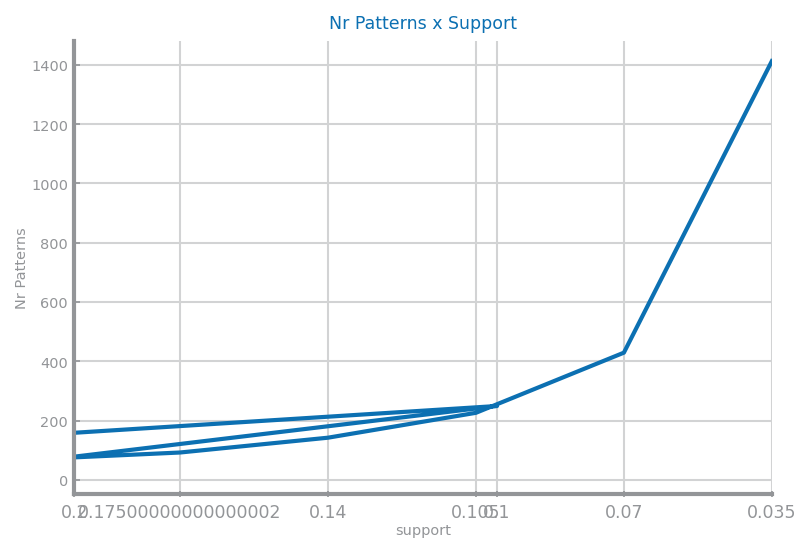

In [5]:
MIN_SUP: float = 0.0035
var_min_sup =[0.2, 0.1] + [i*MIN_SUP for i  in range(100, 0, -10)]

patterns: pd.DataFrame = pm.apriori(data, min_support=MIN_SUP, use_colnames=True, verbose=True)
print(len(patterns),'patterns')
nr_patterns = []
for sup in var_min_sup:
    pat = patterns[patterns['support']>=sup]
    nr_patterns.append(len(pat))

plt.figure(figsize=(6, 4))
ds.plot_line(var_min_sup, nr_patterns, title='Nr Patterns x Support', xlabel='support', ylabel='Nr Patterns')
plt.show()

# Association Rules

In [6]:
MIN_CONF: float = 0.1
rules = pm.association_rules(patterns, metric='confidence', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 435047 rules


In [7]:
def plot_top_rules(rules: pd.DataFrame, metric: str, per_metric: str) -> None:
    _, ax = plt.subplots(figsize=(6, 3))
    ax.grid(False)
    ax.set_axis_off()
    ax.set_title(f'TOP 10 per Min {per_metric} - {metric}', fontweight="bold")
    text = ''
    cols = ['antecedents', 'consequents']
    rules[cols] = rules[cols].applymap(lambda x: tuple(x))
    for i in range(len(rules)):
        rule = rules.iloc[i]
        text += f"{rule['antecedents']} ==> {rule['consequents']}"
        text += f"(s: {rule['support']:.2f}, c: {rule['confidence']:.2f}, lift: {rule['lift']:.2f})\n"
    ax.text(0, 0, text)
    plt.show()

def analyse_per_metric(rules: pd.DataFrame, metric: str, metric_values: list) -> list:
    print(f'Analyse per {metric}...')
    conf = {'avg': [], 'top25%': [], 'top10': []}
    lift = {'avg': [], 'top25%': [], 'top10': []}
    top_conf = []
    top_lift = []
    nr_rules = []
    for m in metric_values:
        rs = rules[rules[metric] >= m]
        nr_rules.append(len(rs))
        conf['avg'].append(rs['confidence'].mean(axis=0))
        lift['avg'].append(rs['lift'].mean(axis=0))

        top_conf = rs.nlargest(int(0.25*len(rs)), 'confidence')
        conf['top25%'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(int(0.25*len(rs)), 'lift')
        lift['top25%'].append(top_lift['lift'].mean(axis=0))

        top_conf = rs.nlargest(10, 'confidence')
        conf['top10'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(10, 'lift')
        lift['top10'].append(top_lift['lift'].mean(axis=0))

    _, axs = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)
    ds.multiple_line_chart(metric_values, conf, ax=axs[0, 0], title=f'Avg Confidence x {metric}',
                           xlabel=metric, ylabel='Avg confidence')
    ds.multiple_line_chart(metric_values, lift, ax=axs[0, 1], title=f'Avg Lift x {metric}',
                           xlabel=metric, ylabel='Avg lift')
    plt.show()

    plot_top_rules(top_conf, 'confidence', metric)
    plot_top_rules(top_lift, 'lift', metric)

    return nr_rules

# Quality evaluation per support

Analyse per support...


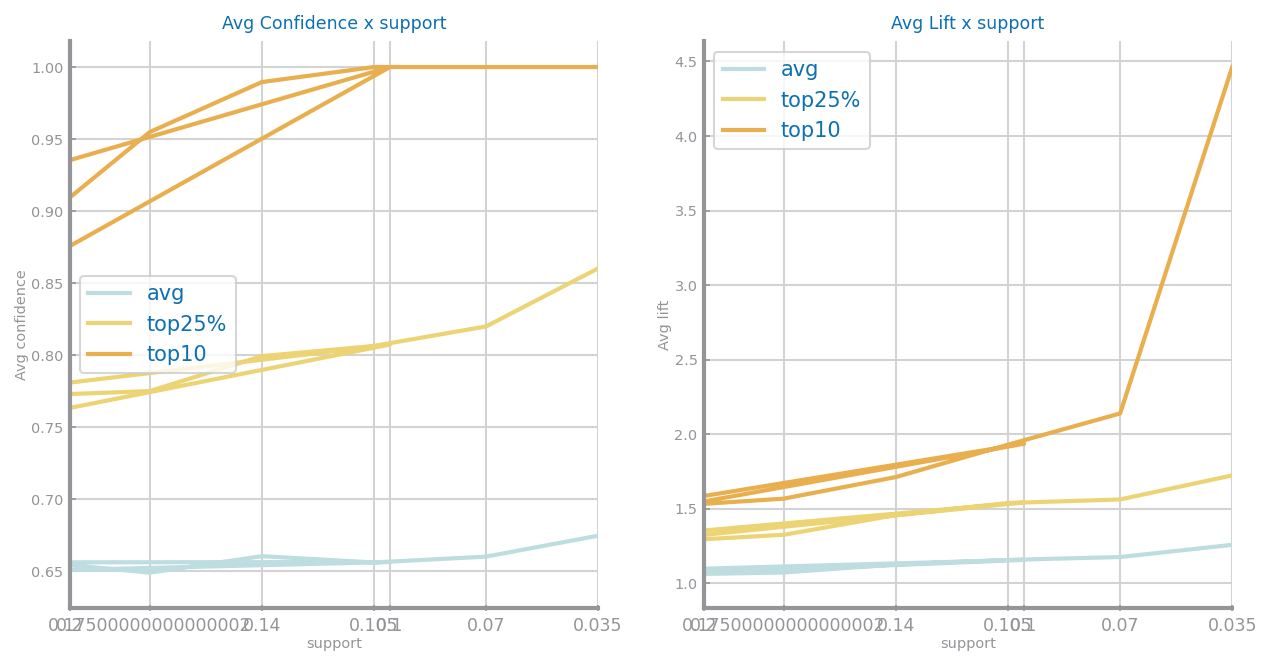

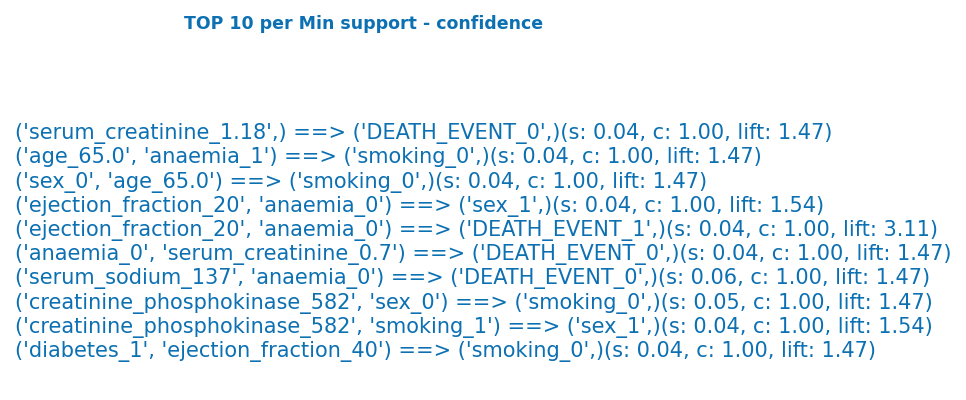

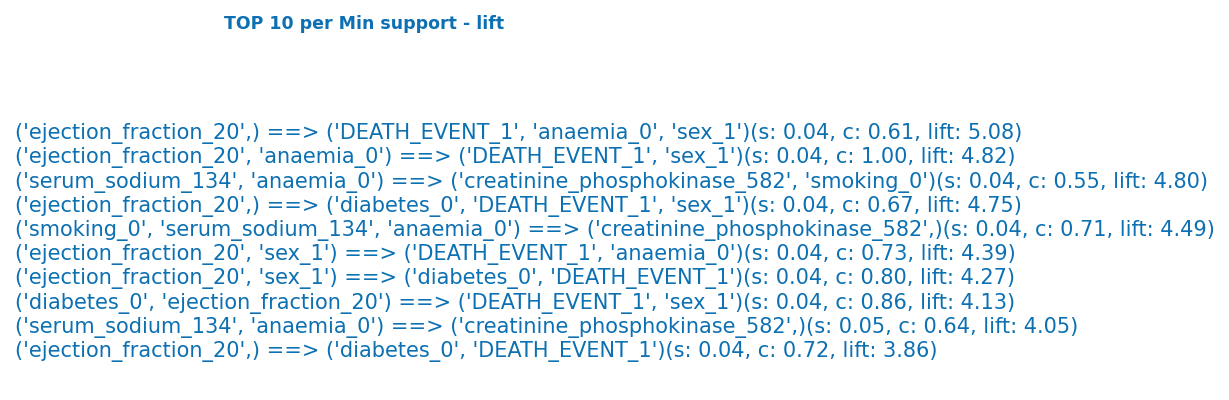

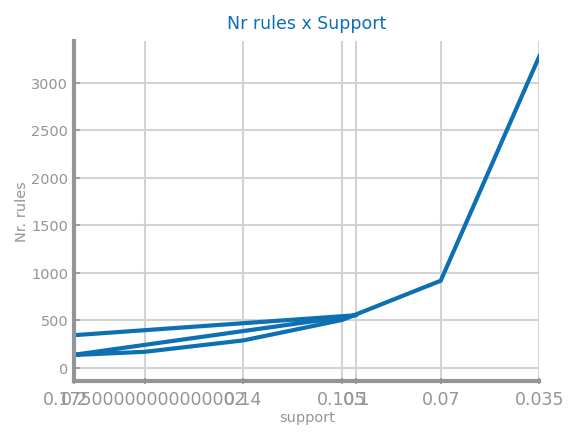

In [8]:
nr_rules_sp = analyse_per_metric(rules, 'support', var_min_sup)
ds.plot_line(var_min_sup, nr_rules_sp, title='Nr rules x Support', xlabel='support', ylabel='Nr. rules', percentage=False)

# Quality evaluation per confidence

Analyse per confidence...


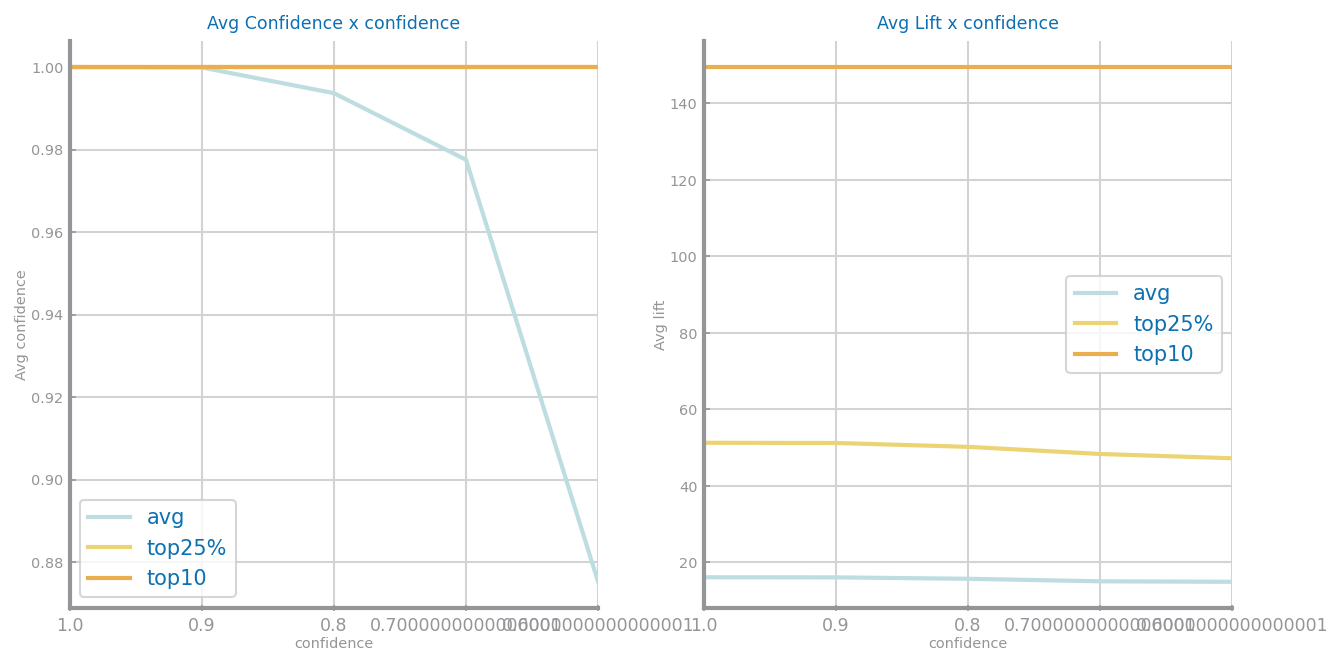

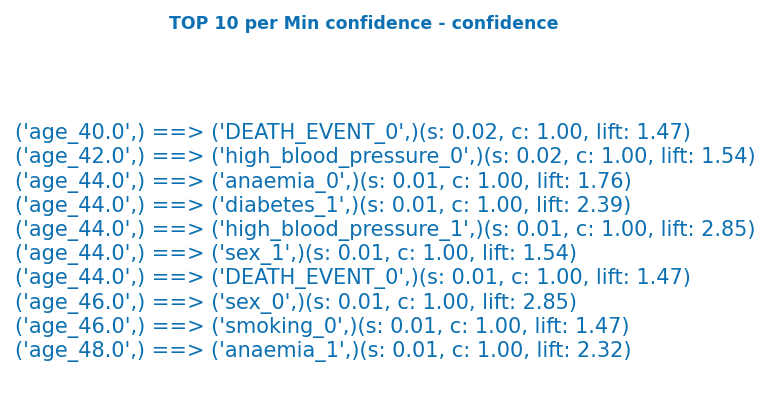

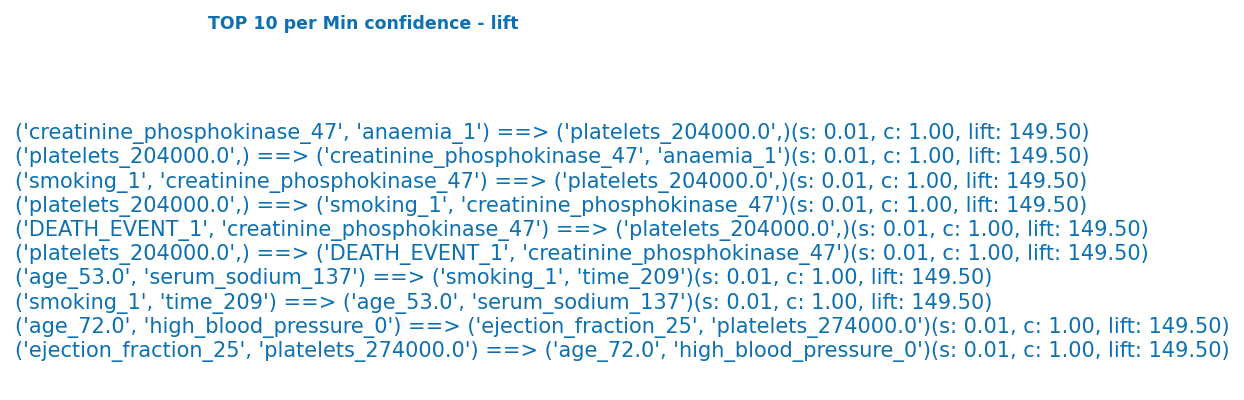

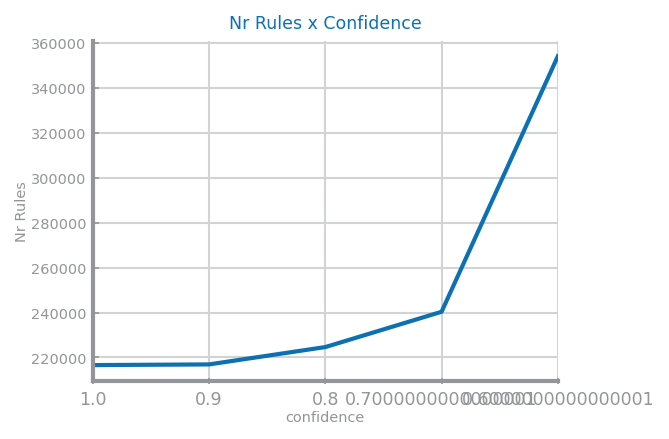

In [9]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
nr_rules_cf = analyse_per_metric(rules, 'confidence', var_min_conf)
ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x Confidence', xlabel='confidence', ylabel='Nr Rules', percentage=False)